# Find the nuclei in divergent images with U-Net implemented in Pytorch

### Why detect nuclei?

From the [2018 Data Science Bowl Project Description](https://www.kaggle.com/c/data-science-bowl-2018)

> Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.

> By participating, teams will work to automate the process of identifying nuclei, which will allow for more efficient drug testing, shortening the 10 years it takes for each new drug to come to market.

[From the video with Dr. Anne Carpenter, Ph.D., Director, Imaging Platform, Broad Institute](https://youtu.be/Dbiq6l50zO8):

> One major bottleneck in the search for effective medicines is finding nuclei in microscopy images. We often want to test thousands of chemicals to find one that might be a good drug. Scientists prepare batches of cells, add a chemical to each batch, and take pictures of each cell. They want to see which cells respond in a certain way that indicates the cells are healthier."

> We need software to help analyze the cells health because robots exist to prepare batches of cells, and to add compounds to the cells, and take microscopy images. A major bottleneck is analyzing the cell images for whatever characteristic the disease expert is studying. **The first step in analyzing images for a particular disease is often to identify nuclei.** 

![microscopy_image](unet_image_assets/microscopy_examples.png)

The images above show different parts of a cell using different types of stains. The image optimized for revealing the nucleus clearly shows more distinctness between other objects in the image. That stain is labeling DNA in the nucleus, which is usually located in the center of a cell. The nuclei also tends to be the most distinguishable part of the cell. From there, software can discern other properties of the cell to determine the disease state.

Scientists currently use classic image algorithms which tend to fail on detecting nuclei which are oddly shapped or with tissue samples. A deep learning model that could find these nuclei could save researchers hundreds of thousands of hours a year. 

### Project Requirements

**The model will be trained with a variety of microscopy images as the purpose is to develop a robust model.** They want one model that works across experimental systems: different stains, species, and microscopes. Scientists generally lack the expertise to train their own models, so their hope is that oe model can mostly do the work instead of highly customized solutions for each situation.


# Examining the data

In [9]:
# import imageio
from pathlib import Path
import numpy as np

In [4]:
path = Path('data/all')
path_train = path/'stage1_train'

## File structure

Each training example is contained in its own folder titled the name of the training image. 

Let's look at one of the example, `0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9`. For brevity, we'll call it `training_image_1`.

`training_image_1` is a folder, with an associated training image: `training_image_1/images/training_image_1.png`. It also has a labeled set of masks in `training_image_1/masks/` where each individual image in the masks directory corresponds to specific labeled object in the image.

Here is the folder structure of the training set:

* stage1_train
    * training_image_1
        * images
            * training_image_1.png
        * masks
            * mask1.png
            * mask2.png

All images in the dataset are PNGs and therefore, RGBA. Per the competition host, we can dispose of the alpha channels since they are unused.

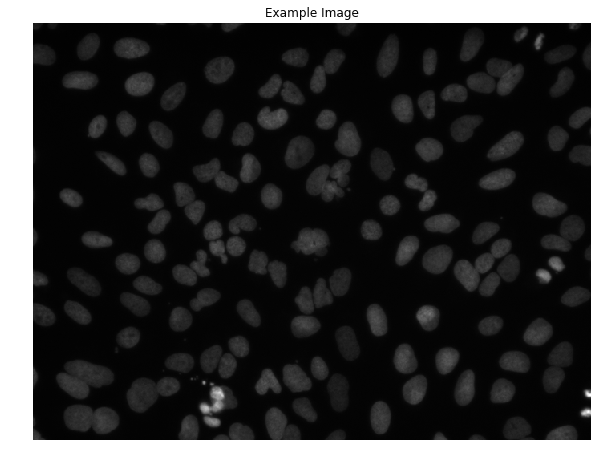

In [6]:
import matplotlib.pyplot as plt
import skimage.io

image_id = '3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e'
image_file = "data/all/stage1_train/{}/images/{}.png".format(image_id, image_id)

image = skimage.io.imread(image_file)

plt.figure(figsize=(10, 20))

plt.imshow(image)
plt.axis('off')
plt.title('Example Image')

plt.show()

To see how the labeled masks look with the original image, we need to load all the masks with `imread_collection` and concatenate the image information to a list.

`read_image_labels` takes a particular image ID, and finds the corresponding image and list of masks.

It then creates an empty matrix the size of the training image, and then goes through each mask to find non-zero values, whereby it marks it in the empty matrix with the image index value. So if the top left corner of a training image is labeled by mask_146 in the list, then `labels` will mark the respective coordinate positions with 146.

![diagram2](unet_image_assets/mask_diagram.png)

In this simplified diagram, the training image has two masks. We create a combined mask by iterating through each mask to find where there is a non-zero value, and mark it on the main category matrix by which file index corresponds to the matrix position. Each pixel in the training set only has one category, as confirmed by their comment, "we did as a team agree that whenever two cells overlapped, the top-most cell would be annotated first, then we'd do the second one."

In [349]:
def read_image_labels(image_id):
    # most of the content in this function is taken from'Example Metric Implementation' kernel 
    # by 'William Cukierski'
    image_file = str(path_train/"{}/images/{}.png").format(image_id,image_id)
    mask_file = str(path_train/"{}/masks/*.png").format(image_id)
    image = skimage.io.imread(image_file)
    masks = skimage.io.imread_collection(mask_file).concatenate() 
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint8)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return image, labels

In [351]:
def display_image_with_mask(image_id):
    image, labels = read_image_labels(image_id)

    print("Image:", image_id)
    plt.figure(figsize=(20,20))
    
    # Left Image - Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')

    # Right Image - Associated Mask
    plt.subplot(1, 2, 2)
    plt.imshow(labels)
    plt.axis('off')
    plt.title('Labeled Mask')
    
    # plt.colorbar()
    plt.show()

There's a a mixture of bright-field and fluorescence microscopy.

Bright-field: Using white light as lumination.

Fluorescence: Fluorophores are added to stain structures in the sample and filters to illuminate it. You can then focus the light emitted by the sample and add a sensitive detector to conduct fluorescence microscopy. Fluorescence microscopy gives the advantage of better resolution by making various structures in the cells contrast better with their neighbors, as well as allowing you to collect images in more than one color.

Image: 3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e


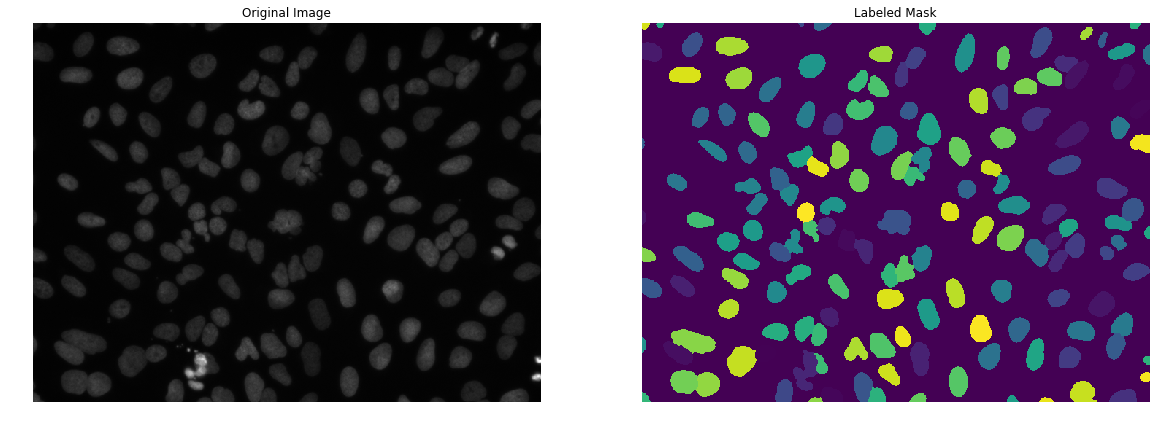

In [96]:
image_id = '3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e'
display_image_with_mask(image_id)

Image: 136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261
image shape: (256, 320, 4)
mask shape: (256, 320)


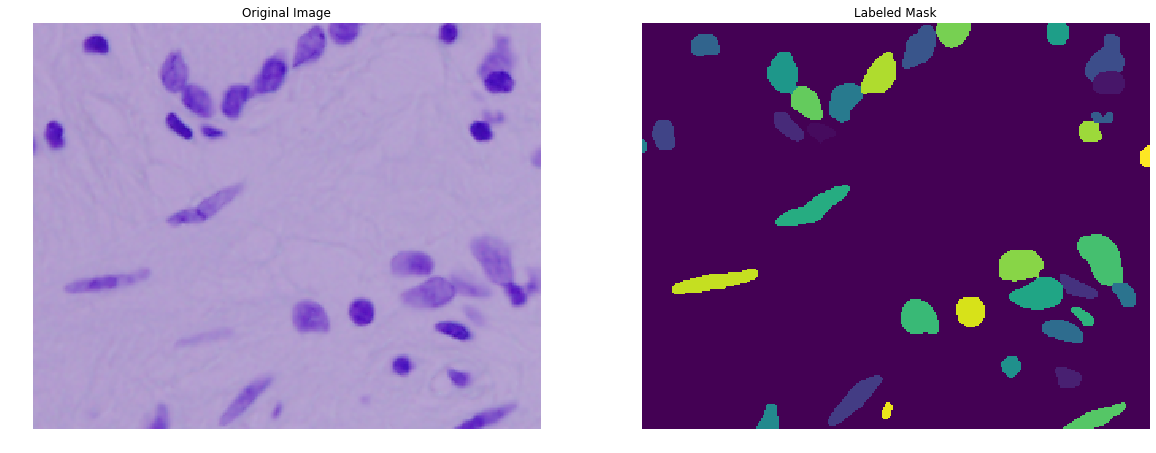

In [92]:
image_id = '136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261'
display_image_with_mask(image_id)

Image: 1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e


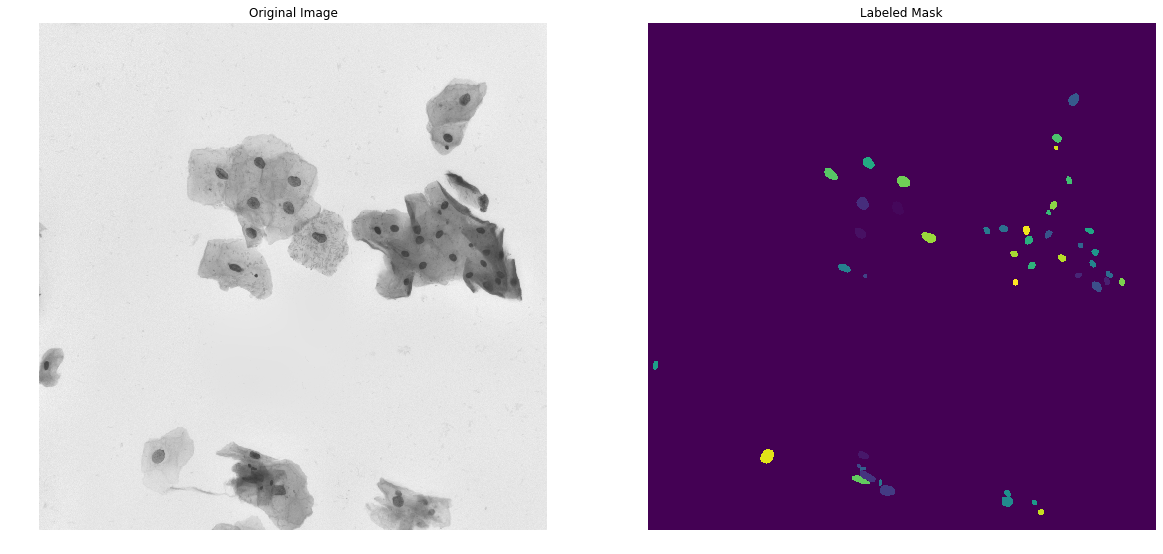

In [88]:
image_id = '1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e'
display_image_with_mask(image_id)

Issues with the training images:

* There are pixels in the image which aren't part of a complete cell mask
* Some cells are combined into a single image
* Some nuclei aren't labeled
* Images have alpha channel which isn't being used

### DataImage class

The DataImage class is what I'm using to convert the file folders into information that later steps can use.

When I import the image, I drop the alpha channel since none of the medical images are using it.

I'm also converting the label datatype to unit8, which limits the number of objects to 255 but is required in order PIL to be able to convert the matrix into PIL format.

In [181]:
class DataImage():
    def __init__(self, image_id, has_mask=True):
        if has_mask:
            self.image_id = image_id
            self.image_path = str(path_train/image_id/'images'/image_id) + ".png"
            self.image = skimage.io.imread(self.image_path)[:, :, :3]
            self.height, self.width, _ = self.image.shape

            self.masks = self.generate_masks(image_id)
            self.label = self.generate_flat_mask(self.masks)

    def generate_flat_mask(self, masks):
        labels = np.zeros((self.height, self.width), dtype=np.uint8)
        for i in range(len(masks)):
            labels[masks[i] > 0] = i + 1
        return labels
    
    def show_image(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.image)
        plt.title(self.image_id)
        plt.axis('off')
        plt.show()
        
    def show_mask(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.label)
        plt.title(self.image_id)
        plt.axis('off')
        plt.show()
    
    def __str__(self):
        return str(self.image_id)

    @staticmethod
    def generate_masks(image_id):
        mask_file = str(path_train/"{}/masks/*.png").format(image_id)
        masks = skimage.io.imread_collection(mask_file).concatenate()
        return masks

Record the list of file folders in a given directory

In [147]:
import os
def list_dir(path):
    """
    Give a list of directory filenames.
    """
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [165]:
directories = list_dir(path_train)
training_ids = [path for path in directories]

print("Number of training examples:", len(training_ids))

Number of training examples: 670


Compile a tuple list containing DataImage objects.

In [183]:
# data_training = tuple(DataImage(image_id) for image_id in training_ids)

### Sanity Check

Let's make sure the data was loaded properly by checking the number of items in the list, and checking random samples in the `tuple`.

In [178]:
len(data_training)

670

In [184]:
random_index = np.random.randint(0, len(images))
print(data_training[random_index])

619429303c1af7540916509fe7900cf483eba4391b06aac87ff7f66ca1ab6483


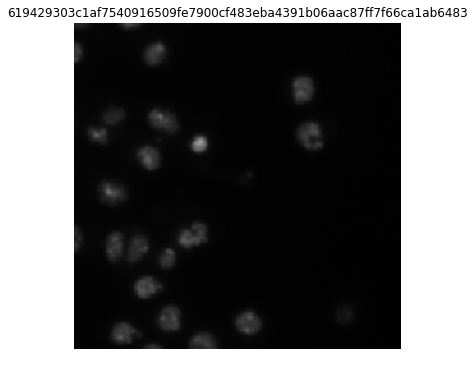

In [185]:
data_training[random_index].show_image()

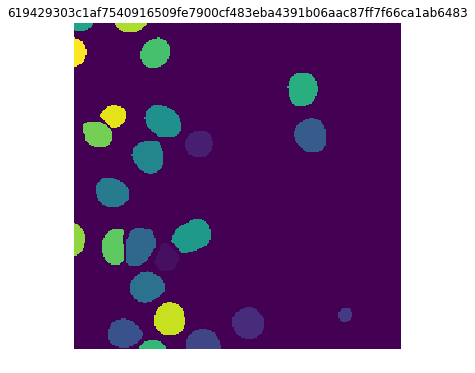

In [186]:
data_training[random_index].show_mask()

In [145]:
data_training[random_index].label

array([[ 0,  0,  0, ..., 14, 14, 14],
       [ 0,  0,  0, ..., 14, 14, 14],
       [ 0,  0,  0, ..., 14, 14, 14],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16)

## Initialize Dataset and DataLoader

In [139]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

Create the `Dataset` for the `DataLoader`

Still unsure if the image transformations make sense for the model. 

In [353]:
from PIL import Image

In [357]:
folders = list_dir(path_train)

In [406]:
class MicrosopicImagesDataset(Dataset):
    def __init__(self, images_folder):
        self.images_folder = images_folder
        
        self.image_ids = [folder for folder in list_dir(self.images_folder)]

        self.transform_image = transform_image
        self.transform_mask = transform_mask
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        self.image_path = str(self.images_folder/image_id/'images'/image_id) + ".png"

        image = Image.open(self.image_path).convert('RGB')
        width, height = image.size
        
        labeled_images = list_labeled_images(self.images_folder, image_id)

        label = create_flat_labeled_image(height, width, labeled_images)
        
        image = self.transform_image(image)
        label = self.transform_mask(np.expand_dims(label, 1))

        return image, label
    
    def __len__(self):
        return len(self.image_ids)

def create_flat_labeled_image(height, width, labeled_images):
    """
    Create a list of matrices containing the labeled information for image_id.
    """
    labels = np.zeros((height, width), dtype=np.uint8)
    for i in range(len(labeled_images)):
        labels[labeled_images[i] > 0] = i + 1
    return labels

def list_labeled_images(path, image_id):
    """
    Create a list of matrices containing the labeled information for image_id.
    """
    mask_file = str(path/"{}/masks/*.png").format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()
    return masks
    
    
transform_image = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_mask = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((388, 388)),
    transforms.ToTensor(),
])

#dataset = MicrosopicImagesDataset(data_training)
dataset = MicrosopicImagesDataset(path_train)

### Sanity Check

Check to make sure the outputs from the `Dataset` are what we expect.

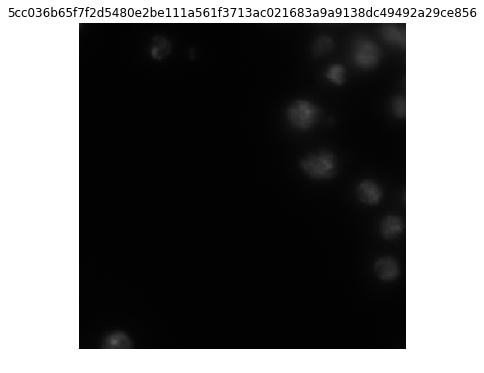

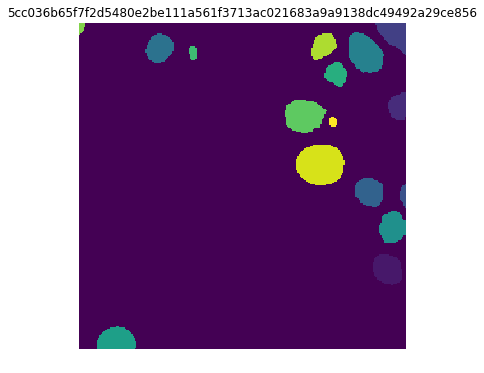

torch.Size([3, 572, 572])
torch.Size([3, 388, 388])
670


In [407]:
image, mask = dataset[0]
print(image.shape)
print(mask.shape)
print(len(dataset))

In [194]:
print(mask[0][2][0])
print(mask[1][2][0])
print(mask[2][2][0])

tensor(0.0431)
tensor(0.0431)
tensor(0.)


## Create a `DataLoader`

In [195]:
dataloader = DataLoader(dataset, batch_size=4)

In [202]:
for images, labels in dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([4, 3, 572, 572])
torch.Size([4, 3, 388, 388])


# Network Model

![unet_model_architecture](unet_image_assets/unet_diagram_2.png)

## Why use U-net?

* The U-net was original created for the purpose of medical imagery segmentation
* The convolution operators results in a spatial contraction where we gradually increase the “what” and reduce the “where”. In essence, I believe they are suggesting that the network is invariant to localization and meat exploit the advantages Deep Neural Networks, namely feature detection.
* It’s an example of a Fully Convolution Network (i.e. no fully connected layers). "Appending a fully connected layer enables the network to learn something using global information where the spatial arrangement of the input falls away and need not apply.”
* Works well inspite of using little training data.


## Code Credit


For the U-net model: Full credit goes to Tuatani Godard's [code](https://github.com/EKami/carvana-challenge/blob/original_unet/src/nn/unet_origin.py) and [tutorial](https://tuatini.me/practical-image-segmentation-with-unet/). I made small adjustments for my purpose, but his code was the basis for the structure.


## nn.Module structure

![nn_module_diagram](unet_image_assets/nn_module_diagram_3.png)

Since the network re-uses a lot of convolutional operations, Godard's implementation seperated the `nn.Modules` in a hierarchy where the Unet uses Contracting and Expansive segments, which in turn use convolutional operations to create feature maps.

### Convolution Module

![convolutional_layer](unet_image_assets/convolution_operator_diagram_2.png)

Per the suggestion of Tuatani Godard, I include batch normalization to speed up optimization.


In [253]:
class ConvBnRelu(nn.Module):
    """
    Layer containing a convolution, followed by batch normalization and ReLU.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, input_data):
        output = self.conv(input_data)
        output = self.bn(output)
        output = self.relu(output)
        return output

### Contracting Segment

> The network architecture ... consists of the repeated application of two 3x3 convolutions (**unpadded convolutions**), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

We'll also need to keep a record of the parameter prior to the downsampling so that they can be concatenated to the upsample version.

In [258]:
class ContractingStack(nn.Module):
    """
    Stack of convolution/batch norm/relu layers, followed by a max pool.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convbnrelu_1 = ConvBnRelu(in_channels, out_channels, 3, 0, 1)
        self.convbnrelu_2 = ConvBnRelu(out_channels, out_channels, 3, 0, 1)
        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, input_data):
        output = self.convbnrelu_1(input_data)
        output = self.convbnrelu_2(output)
        output_trace = output
        output = self.maxpool(output)
        return output, output_trace

### Expansive Segment

![expansive_segment](unet_image_assets/expansive_segment.png)

### Concatenation Operation for the Expansive Segment

![concat_operation](unet_image_assets/concatenation_operation_diagram_2.png)

The most complicated part of the upsampling procedure is cropping and concatenating the associated downsampling feature map. Let's pretend we have two tensors of equal depth, but different height and width.

> Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. **The cropping is necessary due to the loss of border pixels in every convolution.**


In [209]:
down_tensor = torch.empty(128, 280, 280)
print("Down tensor:", down_tensor.size())

up_tensor = torch.empty(128, 200, 200)
print("Up sampled tensor:", up_tensor.size())

Down tensor: torch.Size([128, 280, 280])
Up sampled tensor: torch.Size([128, 200, 200])


We can't concatenate tensor by the filter length if we have different height and width.

In [210]:
matrix3 = torch.cat((down_tensor, up_tensor), 0)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 280 and 200 in dimension 1 at /Users/administrator/nightlies/2018_11_29/wheel_build_dirs/conda_3.6/conda/conda-bld/pytorch-nightly_1543487697672/work/aten/src/TH/generic/THTensorMoreMath.cpp:1325

To fix this, the paper crops the associated `down_tensor` around the center.

In [211]:
c = (down_tensor.size()[2] - up_tensor.size()[2]) // 2
print("Padding amount:", c)
print("New size:", (-c, -c, -c, -c))

new_bypass = F.pad(down_tensor, (-c, -c, -c, -c))
print("New bypass:", new_bypass.size())

concat_matrix = torch.cat((up_tensor, new_bypass), 0)

print(concat_matrix.size())

Padding amount: 40
New size: (-40, -40, -40, -40)
New bypass: torch.Size([128, 200, 200])
torch.Size([256, 200, 200])


In [340]:
class ExpansiveStack(nn.Module):
    """
    Stack of layers expanding the feature map using concatenation.
    """
    def __init__(self, in_channels, out_channels, upsample_size):
        super().__init__()
        self.upsample = nn.Upsample(upsample_size, mode="bilinear")
        self.convbnrelu1 = ConvBnRelu(in_channels, out_channels, 3, 0, 1)
        self.convbnrelu2 = ConvBnRelu(in_channels, out_channels, 3, 0, 1)
        
    def _crop_concat(self, upsampled, downsample_map):
        """
        A concatenation with the correspondingly cropped
        feature map from the contracting path
        """
        crop_size = (downsample_map.size()[2] - upsampled.size()[2]) // 2
        cropped = F.pad(downsample_map, (-crop_size, -crop_size, -crop_size, -crop_size))
        return torch.cat((upsampled, cropped), 1) # Have to account for entry 0, batch_size
    
    def forward(self, input_data, down_tensor):
        output = self.upsample(input_data)
        print(f"Upsample Dimension: {output.shape}")
        output = self.convbnrelu1(output)
        print(f"Convolution Dimension 1: {output.shape}")
        output = self._crop_concat(output, down_tensor)
        print(f"Post Concat: {output.shape}")
        output = self.convbnrelu2(output)
        print(f"Convolution Dimension 2: {output.shape}\n")
        return output
        

## Full Architecture

>  At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

In [344]:
class UNet(nn.Module):
    """
    UUNet implementation with Batch Normalization.
    """
    def __init__(self, in_shape):
        
        super().__init__()
        channels, height, width = in_shape
        
        # Downsample the image
        self.down1 = ContractingStack(channels, 64)
        self.down2 = ContractingStack(64, 128)
        self.down3 = ContractingStack(128, 256)
        self.down4 = ContractingStack(256, 512)
        
        # For the center, do two convolutional operations but
        # don't need to apply maxpool
        self.center = nn.Sequential(ConvBnRelu(512, 1024, 3, 0, 1), 
                                    ConvBnRelu(1024, 1024, 3, 0, 1))
        
        self.up1 = ExpansiveStack(1024, 512, (56, 56))
        self.up2 = ExpansiveStack(512, 256, (104, 104))
        self.up3 = ExpansiveStack(256, 128, (200, 200))
        self.up4 = ExpansiveStack(128, 64, (392, 392))
        
        self.output_seg_map = nn.Conv2d(64, 1, 1, 1)
        
    def forward(self, x):
        
        x, xtrace_1 = self.down1(x)
        x, xtrace_2 = self.down2(x)
        x, xtrace_3 = self.down3(x)
        x, xtrace_4 = self.down4(x)
        
        x = self.center(x)

        print(f"Center Layer Dimension: {x.shape}\n")
        
        x = self.up1(x, xtrace_4)
        x = self.up2(x, xtrace_3)
        x = self.up3(x, xtrace_2)
        x = self.up4(x, xtrace_1)
        
        output = self.output_seg_map(x)
        output = torch.squeeze(output, 1)
        
        return output

### Sanity Check

Ensure that the network can make a prediction without encounntering an error.

In [345]:
input_size = (3, 572, 572)
sample_model = UNet(input_size)

In [317]:
example_image = transform_image(data_training[0].image).unsqueeze(0)
example_image.shape

torch.Size([1, 3, 572, 572])

In [346]:
prediction = sample_model(example_image)

Center Layer Dimension: torch.Size([1, 1024, 28, 28])

Upsample Dimension: torch.Size([1, 1024, 56, 56])
Convolution Dimension 1: torch.Size([1, 512, 54, 54])
Post Concat: torch.Size([1, 1024, 54, 54])
Convolution Dimension 2: torch.Size([1, 512, 52, 52])

Upsample Dimension: torch.Size([1, 512, 104, 104])
Convolution Dimension 1: torch.Size([1, 256, 102, 102])
Post Concat: torch.Size([1, 512, 102, 102])
Convolution Dimension 2: torch.Size([1, 256, 100, 100])

Upsample Dimension: torch.Size([1, 256, 200, 200])
Convolution Dimension 1: torch.Size([1, 128, 198, 198])
Post Concat: torch.Size([1, 256, 198, 198])
Convolution Dimension 2: torch.Size([1, 128, 196, 196])

Upsample Dimension: torch.Size([1, 128, 392, 392])
Convolution Dimension 1: torch.Size([1, 64, 390, 390])
Post Concat: torch.Size([1, 128, 390, 390])
Convolution Dimension 2: torch.Size([1, 64, 388, 388])



## Optimization

From the winning team:

> For networks with sigmoid activation and 2 channel masks we used combination of binarycrossentropy with softdice per channel. For networks with softmax activation and 3 channel masks we used combination of categoricalcrossentropy with softdice per channel (soft dice was applied only to mask and border channels).



In [347]:
prediction.shape

torch.Size([1, 388, 388])